## Data Analysis Example: How can you get the five year average propane injections for a given region (Eastern Canada) ?

Note - with heating commodities, the five year average is used to compare the current years statistics with the previous five years. So the current five year average would include 2015 - 2019 (inclusive)


If you cant remember the exact code/functions to use, start writing down the steps that could make this happen.

First step: Import all the modules we need

In [78]:
import pandas as pd
import dateutil.relativedelta as relativedelta
import datetime

In [79]:
df = pd.read_excel('2020lqdptrlmgs.xlsx',sheet_name = 'Data') #read from a saved dataset

In [80]:
df.head()

,Region / Région,Date,Spec. propane / propane pur,Total butane / butane - total,Normal butane / butane normal,Iso-butane,Total mix / mélange - total,C2 in mix / mélange - C2,C3 in mix / mélange - C3,C4 in mix / mélange - C4,Other in mix / mélange - autres
0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654
1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000
2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180
3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138
4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209


In [81]:
# previously defined functions
def english_only(col_names):
    return {x:x.split('/')[0].strip() for x in col_names}


def change_units(df):
    for col in df:
        if col not in ['Region','Date']:
            df[col] = (df[col]*1000)*6.2898 #note, we are accessing the column with a variable name
    return df


def calculate_injections(df):
    grouped = df.groupby('Region')
    new_group = []
    for name, group in grouped:
        group = group.copy()
        group['propane injection'] = group['Spec. propane'] - group['Spec. propane'].shift(1)
        new_group.append(group)
    df = pd.concat(new_group, ignore_index=True)
    return df

In [82]:
# step 1: data cleaning/preperation
df = df.rename(columns=english_only(df.columns))
df['Region'] = df['Region'] = df['Region'].replace(english_only(df['Region'].unique()))
df = calculate_injections(df)
# df_bbl = change_units(df)

In [83]:
df.head()

,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix,propane injection
0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654,NaN
1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000,-427.512809
2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180,-182.959574
3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138,123.818326
4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209,298.682685


In [84]:
region = 'Eastern Canada'

In [85]:
df5 = df[df['Region']==region][['Date','propane injection']]
#df5['Year'] = [x.year for x in df5['Date']]
max_date = df5['Date'].max() 
max_date

Timestamp('2020-06-01 00:00:00')

In [86]:
max_year = max_date - relativedelta.relativedelta(years = 1)
max_year = max_year.year
max_year

2019

In [87]:
min_year = max_year - 4
min_year

2015

In [88]:
df5 = df5[(df5['Date'].dt.year <= max_year) & (df5['Date'].dt.year >= min_year)]

In [89]:
df5.head()
df5.tail()

,Date,propane injection
481,2019-08-01,133.8587
482,2019-09-01,90.5816
483,2019-10-01,54.2802
484,2019-11-01,-56.3411
485,2019-12-01,-67.5746


In [90]:
df5 = df5.groupby(df['Date'].dt.month).mean()
df5

,propane injection
Date,
1,-133.07268
2,-184.02582
3,-138.58406
4,-33.00266
5,59.19534
6,93.41122
7,81.86974
8,117.59776
9,67.29044


In [104]:
import os.path
def five_year_avg(df, region='Eastern Canada', save=True):
    
    #isolate the data for the given region
    df5 = df[df['Region']==region][['Date','propane injection']].copy()
    #get the max and min years for the analysis
    max_date = df5['Date'].max()
    max_year = max_date - relativedelta.relativedelta(years = 1)
    max_year = max_year.year
    min_year = max_year - 5
    #filter the dataframe on two conditions using the "AND" operator
    df5 = df5[(df5['Date'].dt.year <= max_year) & (df5['Date'].dt.year > min_year)]
    df5 = df5.groupby(df['Date'].dt.month).mean()
    #new code to compare the 2020 injections/withdrawls from the average
    
    current_year = max(df[df['Region']==region]['Date'].dt.year)
    df_now = df[(df['Region']==region) & (df['Date'].dt.year == current_year)].copy()
    df_now['Month'] = df_now['Date'].dt.month
    df_now = df_now[['Month','propane injection']]
    
    df5 = df5.merge(df_now,how='left',left_on='Date',right_on='Month',suffixes=('_avg','_now'))
    del df5['Month']
    
    if save and not os.path.isfile(region+'.csv'):
        df5.to_csv(region+'.csv')
    
    print(region)
    df5.plot()
    return df5

Eastern Canada


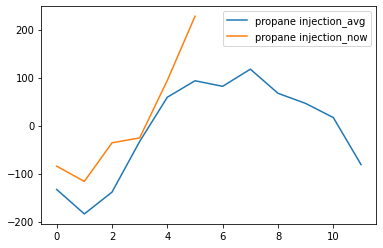

In [105]:
df5 = five_year_avg(df,region = 'Eastern Canada')

## Appendix: data scraping

We do alot of data scraping at the CER. This is how we populate the CERSEI database.

Some websites are easier to scrape than others...

How can we scape the LPG data?

In [93]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [94]:
link = 'https://www.cer-rec.gc.ca/en/data-analysis/energy-commodities/natural-gas-liquids/statistics/2021lqdptrlmgs.xlsx'
df_scrape = pd.read_excel(link,sheet_name='Data')
#can anyone see an issue with this link?

In [106]:
df_scrape.tail()

,Region / Région,Date,Spec. propane / propane pur,Total butane / butane - total,Normal butane / butane normal,Iso-butane,Total mix / mélange - total,C2 in mix / mélange - C2,C3 in mix / mélange - C3,C4 in mix / mélange - C4,Other in mix / mélange - autres
754,Western Canada / Ouest Canadien,2016-09-01,919.9590,567.4040,NaN,NaN,630.7130,67.721690,311.65272,176.47694,74.861650
755,Western Canada / Ouest Canadien,2017-09-01,1117.3860,538.2440,NaN,NaN,332.3560,43.486420,154.06416,90.78572,44.019700
756,Western Canada / Ouest Canadien,2018-09-01,1244.5660,1066.0660,NaN,NaN,712.4176,120.884700,303.85485,202.75780,84.920250
757,Western Canada / Ouest Canadien,2019-09-01,835.5891,607.0191,NaN,NaN,350.5071,60.083235,152.10913,95.55356,42.761175
758,Western Canada / Ouest Canadien,2020-09-01,1477.3688,910.7599,NaN,NaN,783.0129,129.324405,331.25324,221.64724,100.788015


In [107]:
dynamic_link = link.split('/')
dynamic_link[-1][4:]

now = datetime.date.today()
now.year

dynamic_link[-1] = str(now.year)+dynamic_link[-1][4:]
dynamic_link = '/'.join(dynamic_link)
dynamic_link

'https://www.cer-rec.gc.ca/en/data-analysis/energy-commodities/natural-gas-liquids/statistics/2021lqdptrlmgs.xlsx'

In [108]:
#other modules used for webscraping
# import selenium
# from bs4 import BeautifulSoup
# import requests

# How can we consolidate this data analysis example?

Modular code...

In [109]:
def english_only(arr):
    return {x:x.split('/')[0].strip() for x in arr}
    
    
def scrape_data(link='https://www.cer-rec.gc.ca/en/data-analysis/energy-commodities/natural-gas-liquids/statistics/2021lqdptrlmgs.xlsx'):
    dynamic_link = link.split('/')
    dynamic_link[-1][4:]

    now = datetime.date.today()
    now.year
    dynamic_link[-1] = str(now.year)+dynamic_link[-1][4:]
    dynamic_link = '/'.join(dynamic_link)
    df = pd.read_excel(link,sheet_name='Data')
    return df


def process_data(df = scrape_data()):
    new_columns = english_only(df.columns)
    df = df.rename(columns=new_columns)
    
    new_regions = english_only(df['Region'].unique())
    df['Region'] = df['Region'].replace(new_regions)
    return df
    

def calculate_injections(df):
    new_group = []
    for r in df['Region'].unique():
        df_r = df[df['Region']==r].copy()
        df_r = df_r.sort_values(by=['Date'])
        df_r['propane injection'] = df_r['Spec. propane'] - df_r['Spec. propane'].shift(1)
        new_group.append(df_r)
    df = pd.concat(new_group, ignore_index=True)
    return df


# this is the main function
def five_year_avg(region='Eastern Canada', save=True):
    df = process_data()
    df = calculate_injections(df)
    #isolate the data for the given region
    df5 = df[df['Region']==region][['Date','propane injection']].copy()
    #get the max and min years for the analysis
    max_date = df5['Date'].max()
    max_year = max_date - relativedelta.relativedelta(years = 1)
    max_year = max_year.year
    min_year = max_year - 4
    #filter the dataframe on two conditions using the "AND" operator
    df5 = df5[(df5['Date'].dt.year <= max_year) & (df5['Date'].dt.year >= min_year)]
    df5 = df5.groupby(df['Date'].dt.month).mean()
    #new code to compare the 2020 injections/withdrawls from the average
    
    current_year = max(df[df['Region']==region]['Date'].dt.year)
    df_now = df[(df['Region']==region) & (df['Date'].dt.year == current_year)].copy()
    df_now['Month'] = df_now['Date'].dt.month
    df_now = df_now[['Month','propane injection']]
    
    df5 = df5.merge(df_now,how='left',left_on='Date',right_on='Month',suffixes=('_avg','_now'))
    del df5['Month']
    
    if save and not os.path.isfile(region+'.csv'):
        df5.to_csv(region+'.csv')
    
    print(region+' '+str(current_year))
    df5.plot()

Western Canada 2021


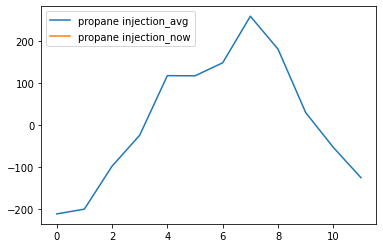

In [111]:
five_year_avg(region='Western Canada',save=False)

### Homework...

How can we modify the code so that the product (Spec. propane, total butane) can be passed into the functions to change which product is displayed in the graph?

### Final Notes:

1) This is a process. Once you get over the "hump" you'll start to find that writing python for your job is easier and faster than using excell for complicated problems.

2) Even if you aern't comfortable with the basics yet, start forcing yourself to do projects in python as opposed to excel.

3) If you feel like putting your fist through the computer screen, that means you are learning...